# Check correlations

1. Abs correlation of each latent feature with the binary attribute (or coefs from reg/lstsq)
2. Which features have reasonably high values for each corr, and how shared they are (norms)
3. For each latent there are norms in each block - multiply by corr
4. Reduce by latent feature (observe that this attribute is “made” in this block  more than others)


## Preliminaries

In [1]:
import os
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sae import Sae

from notebooks.utils import load_sae, get_group_indices, get_group_norms

Triton not installed, using eager implementation of SAE decoder.


In [ ]:
path = "weights2weights/weights_datasets/" 
device = "cuda"

In [3]:
# Load activations
acts = torch.load(f"{path}/activations_20250528_coef10.pt")

In [4]:
# Load weights of corresponding decoder
sae_path = "runs/run_lat5000_bs512_auxk0.03_k256_epoch10_1423773_0"
cfg = json.load(open(f"{sae_path}/config.json") )
norm_type = cfg['sae']["per_block_norm"]
sae = load_sae(sae_path+"/0")
sae.W_dec.shape

torch.Size([5000, 99648])

In [5]:
# Get input norms
dim_df = torch.load(path + "weight_dimensions_extended_df.pt")
input_group_norms = torch.load(path + f"group_norms_{norm_type}.pt")
input_group_norms.shape

torch.Size([7])

In [6]:
decoder_norms = get_group_norms(get_group_indices(dim_df), sae.W_dec, input_group_norms) # already scaled
relative_norms = decoder_norms.div(decoder_norms.sum(dim=1,keepdim=True))
decoder_norms.shape, relative_norms.shape

(torch.Size([5000, 7]), torch.Size([5000, 7]))

In [7]:
# Load identities
df = torch.load(f"{path}/identities/identity_df.pt")
df["filename"] = df.index.str.split(".").str[0]

In [8]:
# Get attributes
filenames = list(acts.keys())
X = torch.stack([acts[f] for f in filenames])

filenames = [os.path.splitext(f)[0] for f in filenames]
df = df.loc[df.filename==filenames]

y_cols = df.drop(columns=["filename", "identity"]).columns
Y = torch.tensor(df[y_cols].values, dtype=torch.float32)

In [9]:
X.shape, Y.shape

(torch.Size([64974, 5000]), torch.Size([64974, 40]))

## Absolute correlation

In [10]:
X_centered = X - X.mean(dim=0, keepdim=True)  # (65000, 5000)
Y_centered = Y - Y.mean(dim=0, keepdim=True)  # (65000, 40)

X_std = X.std(dim=0, unbiased=False)  # (5000,)
Y_std = Y.std(dim=0, unbiased=False)  # (40,)

X_norm = X_centered / X_std  # (90000, 5000)
Y_norm = Y_centered / Y_std  # (90000, 40)

correlation_matrix = torch.matmul(X_norm.T, Y_norm) / X.shape[0]

In [11]:
corr = abs(correlation_matrix)
corr[corr < 0.0] = 0

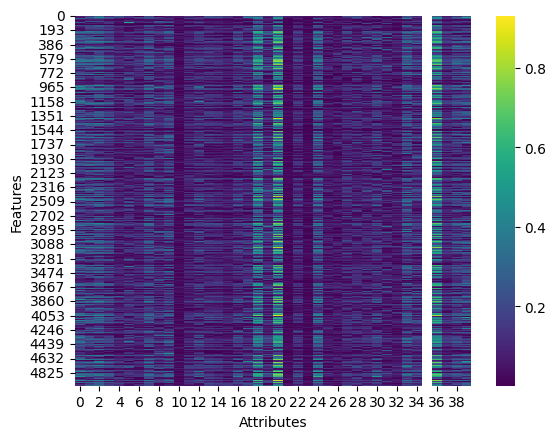

In [12]:
sns.heatmap(corr, cmap="viridis")
plt.xlabel("Attributes")
plt.ylabel("Features")
plt.show()

In [13]:
y_cols[[18,20,36]]

Index(['Heavy_Makeup', 'Male', 'Wearing_Lipstick'], dtype='object')

In [14]:
corr.count_nonzero() / correlation_matrix.nelement()

tensor(1.)

## High correlation and norms

In [15]:
threshold = 0.3 

mask = corr >= threshold  # (5000, 40)
# For each attribute (column), get the feature indices where correlation is high
high_corr_indices = [torch.nonzero(mask[:, i], as_tuple=False).squeeze(1) for i in range(corr.shape[1])]
# sum([i.nelement() for i in high_corr_indices])
high_corr_indices


[tensor([   8,   11,   20,   27,   44,   51,   61,   74,   85,   90,   95,  101,
          107,  109,  120,  127,  131,  132,  133,  136,  138,  142,  145,  146,
          147,  152,  161,  166,  171,  174,  181,  182,  185,  186,  188,  195,
          197,  199,  202,  206,  216,  221,  225,  228,  237,  246,  265,  282,
          283,  287,  295,  298,  311,  314,  317,  324,  326,  338,  339,  340,
          341,  356,  357,  360,  377,  385,  400,  419,  422,  433,  435,  437,
          438,  447,  458,  466,  467,  475,  481,  488,  495,  499,  503,  509,
          513,  514,  521,  522,  523,  528,  531,  536,  538,  542,  543,  547,
          552,  553,  554,  555,  556,  568,  570,  586,  589,  591,  600,  601,
          604,  607,  609,  611,  613,  616,  626,  628,  629,  630,  632,  633,
          636,  641,  646,  647,  652,  654,  656,  663,  668,  677,  678,  692,
          698,  700,  705,  707,  714,  717,  747,  771,  779,  794,  795,  798,
          804,  811,  815,  

In [16]:
from torch.nn.utils.rnn import pad_sequence
idx = pad_sequence(high_corr_indices, batch_first=True,padding_value=-1)

In [17]:
relative_norms.shape, idx.shape

(torch.Size([5000, 7]), torch.Size([40, 2890]))

In [18]:
...

Ellipsis

## With blocks

In [19]:
corr.shape, relative_norms.shape

(torch.Size([5000, 40]), torch.Size([5000, 7]))

In [20]:
corr.device

device(type='cpu')

In [21]:
corr = corr.nan_to_num()
A = corr.cuda().unsqueeze(2)
B = relative_norms.unsqueeze(1)

C = A*B
C.shape

torch.Size([5000, 40, 7])

## Reduce

In [22]:
C_ = C.mean(dim=0)
C_.shape

torch.Size([40, 7])

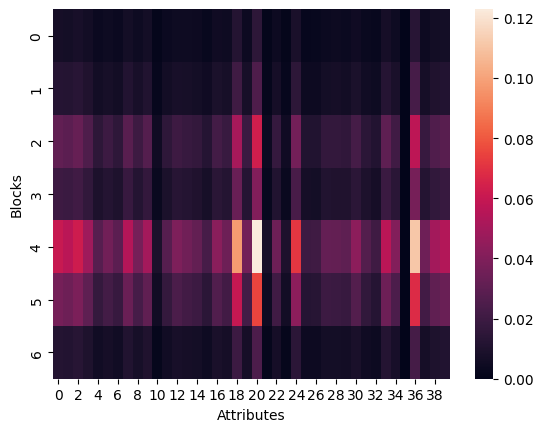

In [23]:
sns.heatmap(C_.T.cpu().detach())
plt.xlabel("Attributes")
plt.ylabel("Blocks")
plt.show()

In [24]:
C_.shape, corr.shape

(torch.Size([40, 7]), torch.Size([5000, 40]))

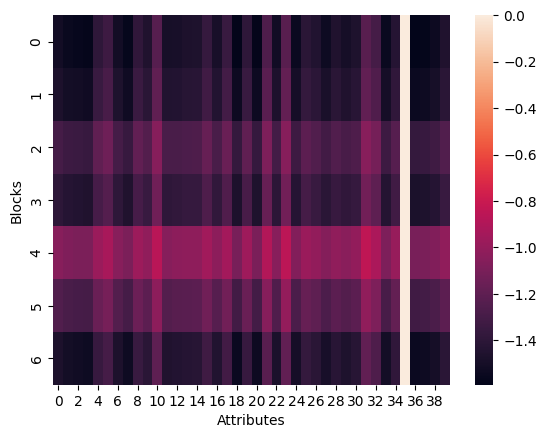

In [25]:
corr_mean = corr.mean(dim=0, keepdim=True).T.cuda()
corr_std = corr.std(dim=0, keepdim=True).T.cuda()
((C_-corr_mean)/corr_std).nan_to_num().shape
sns.heatmap(((C_-corr_mean)/corr_std).nan_to_num().T.cpu().detach())
plt.xlabel("Attributes")
plt.ylabel("Blocks")
plt.show()

In [29]:
C_.shape, corr.shape

(torch.Size([40, 7]), torch.Size([5000, 40]))

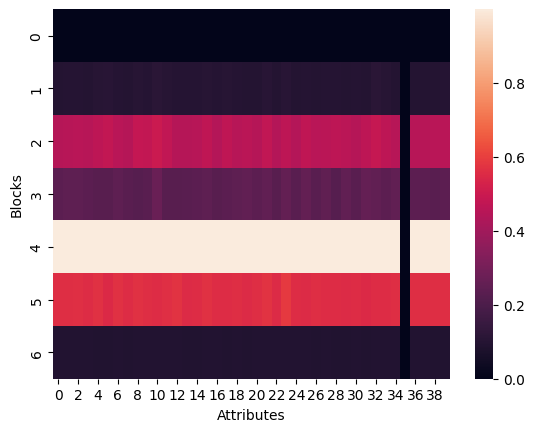

In [30]:
# min_val = corr.min(dim=0, keepdim=True).values.T.cuda()
# max_val = corr.max(dim=0, keepdim=True).values.T.cuda()

min_val = C_.min(dim=1, keepdim=True).values.cuda()
max_val = C_.max(dim=1, keepdim=True).values.cuda()

C_norm = (C_ - min_val) / (max_val - min_val + 1e-8) 

# corr_mean = corr.mean(dim=0, keepdim=True).T.cuda()
# corr_std = corr.std(dim=0, keepdim=True).T.cuda()
# ((C_-corr_mean)/corr_std).nan_to_num().shape
# sns.heatmap(((C_-corr_mean)/corr_std).nan_to_num().T.cpu().detach())
sns.heatmap(C_norm.T.cpu().detach())
plt.xlabel("Attributes")
plt.ylabel("Blocks")
plt.show()

In [27]:
min_val.shape, C_.shape

(torch.Size([40, 1]), torch.Size([40, 7]))

# Ranges of features

In [14]:
a = torch.stack(list(acts.values()))

In [22]:
a.shape

torch.Size([64974, 5000])

In [110]:
a.min(dim=0).values, a.mean(dim=0), a.max(dim=0).values

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([3.5339e-03, 2.5414e-05, 1.3523e-02,  ..., 3.1982e-05, 1.0996e-04,
         2.6472e-04]),
 tensor([0.3766, 0.7725, 0.3323,  ..., 0.9229, 0.5338, 0.3695]))

torch.Size([4176, 1])

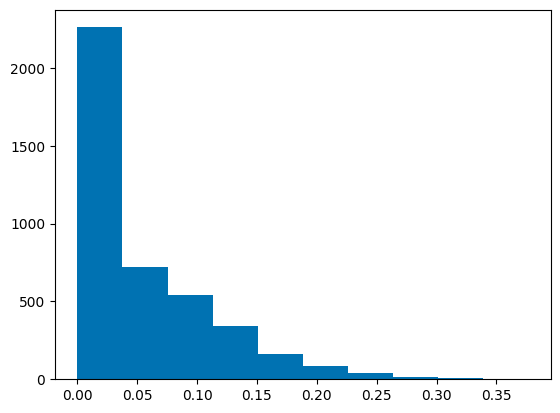

In [28]:
i = 0
row = a[:,i]
plt.hist(row[row.nonzero()])
row[row.nonzero()].shape
# plt.yscale('log')

In [33]:
stats = torch.zeros((a.shape[1], 3))

In [36]:
for i in range(a.shape[1]):
    row = a[:,i]
    nnz = row[row.nonzero()]
    min_ = nnz.min()
    mean_ = nnz.mean()
    max_ = nnz.max()
    stats[i] = torch.tensor([min_, mean_, max_])

In [37]:
stats

tensor([[2.0581e-05, 5.4983e-02, 3.7660e-01],
        [2.3778e-05, 5.0037e-02, 7.7252e-01],
        [1.2871e-06, 3.9375e-02, 3.3226e-01],
        ...,
        [4.5073e-04, 5.4685e-02, 9.2294e-01],
        [1.4089e-05, 2.9770e-02, 5.3383e-01],
        [6.1859e-05, 3.9907e-02, 3.6953e-01]])

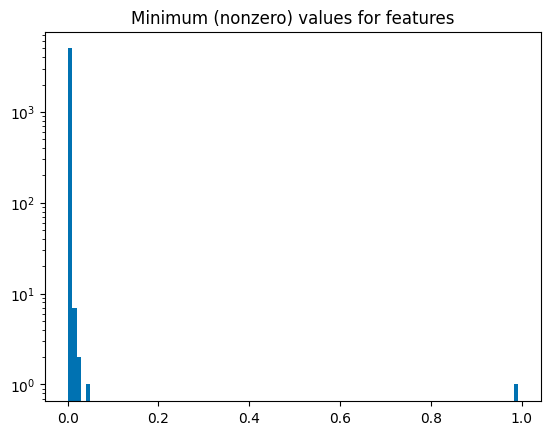

In [51]:
plt.hist(stats[:, 0], bins=100)
plt.title("Minimum (nonzero) values for features")
plt.yscale("log")
plt.show()

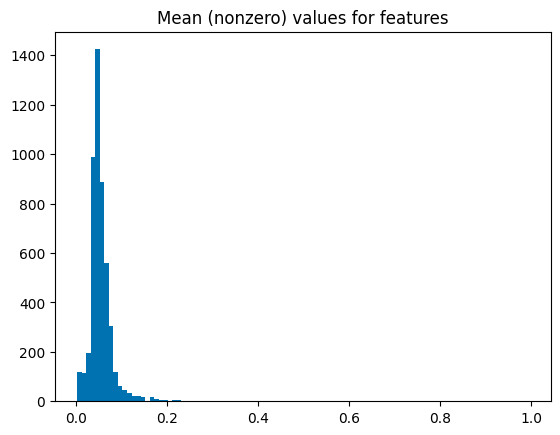

In [52]:
plt.hist(stats[:, 1], bins=100)
plt.title("Mean (nonzero) values for features")
plt.show()

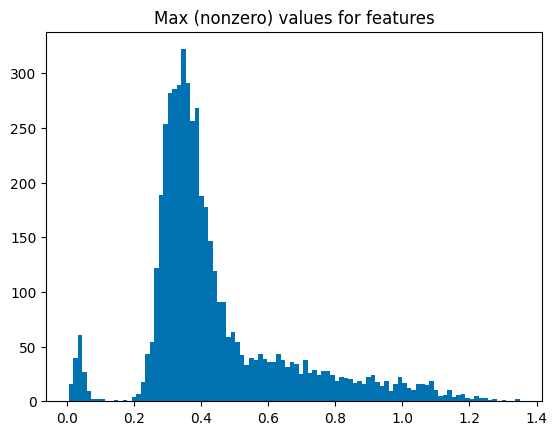

In [53]:
plt.hist(stats[:, 2], bins=100)
plt.title("Max (nonzero) values for features")
plt.show()

In [56]:
torch.save(stats, f"{path}/acts_clamps_20250528.pt")